# Introduction
The default unit if Haoyuan's notebook on the quasi-linear project is 
1. um
2. fs
3. keV

I always use np.fft.fftn to convert the electric field in to the spectrum
and use np.fft.ifftn to convert the spectrum to electric field

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

plt.rcParams.update({'font.size': 16})

sys.path.append("../XRaySimulation/")
from XRaySimulation import util, Pulse, Crystal, DeviceSimu
#from XRaySimulation.GPU import GPUMultiDevice

# Load the central slice of the Genesis electric field

In [2]:
pulseIdx = 3

# Load the 2d pulse
eFieldInitial = np.load(
    '/mnt/c/Users/haoyuan/Desktop/PosDoc/BraggTG/output/efield_genesis_central_2d_{}.npy'.format(pulseIdx))

nx = eFieldInitial.shape[0]
nz = eFieldInitial.shape[1]
dx = 4.32  # um
dz = 0.001261043  #um

# Downsample along the z axis
bin_z = 8
dz = dz * bin_z
eFieldInitial = eFieldInitial[:, ::bin_z]
nz = eFieldInitial.shape[1]

# Pad the electrid field 
nx_new = 2 ** 9
nz_new = 2 ** 14
pad_x_1 = (nx_new - nx) // 2
pad_x_2 = nx_new - nx - (nx_new - nx) // 2
pad_z_1 = (nz_new - nz) // 2
pad_z_2 = nz_new - nz - (nz_new - nz) // 2

eFieldInitial = np.pad(eFieldInitial, pad_width=((pad_x_1, pad_x_2),
                                                 (pad_z_1, pad_z_2),),
                       mode='constant')
nx = eFieldInitial.shape[0]
nz = eFieldInitial.shape[1]

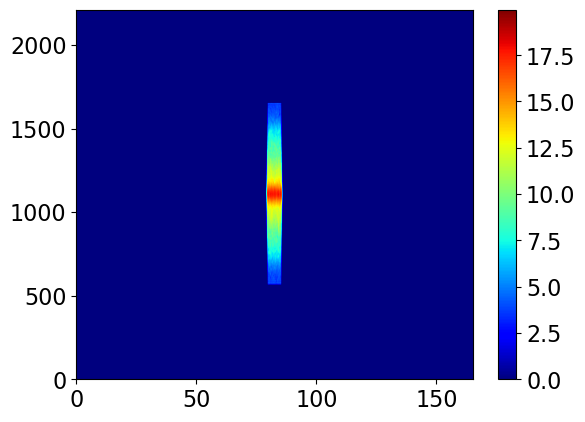

In [25]:
fig, axis = plt.subplots(ncols=1, nrows=1)
im = axis.imshow(np.log(np.square(np.abs(eFieldInitial)) + 1),
                 cmap='jet',
                 extent=[0, nz * dz, 0, nx * dx], aspect='auto')
fig.colorbar(ax=axis, mappable=im)
plt.show()

# Create the associated coordinate system

In [26]:
xCoor = np.arange(nx) * dx
zCoor = np.arange(nz) * dz
tCoor = zCoor / util.c

# Define the central wavelength
wavelength0 = 0.123984193 / 1000
k0 = np.pi * 2 / wavelength0
E0 = util.wavevec_to_kev(k0)

print("The wavelength is {:.2f} nm".format(1000 * wavelength0))

# Get k mesh
kxCoor = np.fft.fftshift(np.fft.fftfreq(nx, d=dx) * 2 * np.pi)
kzCoor = np.fft.fftshift(np.fft.fftfreq(nz, d=dz) * 2 * np.pi)
kzCoor += k0

# Convert wavevector to photon energy for illustration
ExCoor = util.wavevec_to_kev(kxCoor)
EzCoor = util.wavevec_to_kev(kzCoor - k0)

The wavelength is 0.12 nm


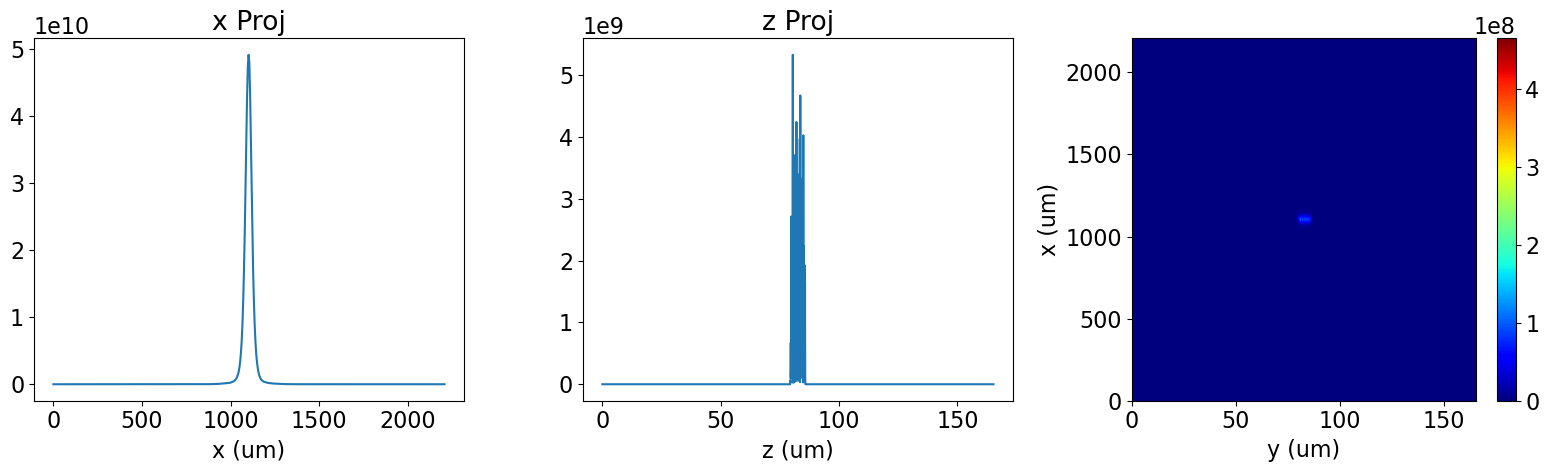

In [27]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(5)
fig.set_figwidth(16)

field_to_process = np.square(np.abs(eFieldInitial))
x_proj = np.sum(field_to_process, axis=1)
z_proj = np.sum(field_to_process, axis=0)

axes[0].plot(xCoor, x_proj)
axes[0].set_title("x Proj")
axes[0].set_xlabel("x (um)")

axes[1].plot(zCoor, z_proj)
axes[1].set_title("z Proj")
axes[1].set_xlabel("z (um)")

img1 = axes[2].imshow(field_to_process, aspect="auto", cmap='jet',
                      extent=[zCoor.min(), zCoor.max(), xCoor.min(), xCoor.max(), ])
fig.colorbar(img1, ax=axes[2])
axes[2].set_ylabel("x (um)")
axes[2].set_xlabel("y (um)")

plt.tight_layout()
plt.show()

In [28]:
# Convert the initial eField to spectrum
eSpectrumInitial = np.fft.fftshift(np.fft.fftn(eFieldInitial))
del eFieldInitial

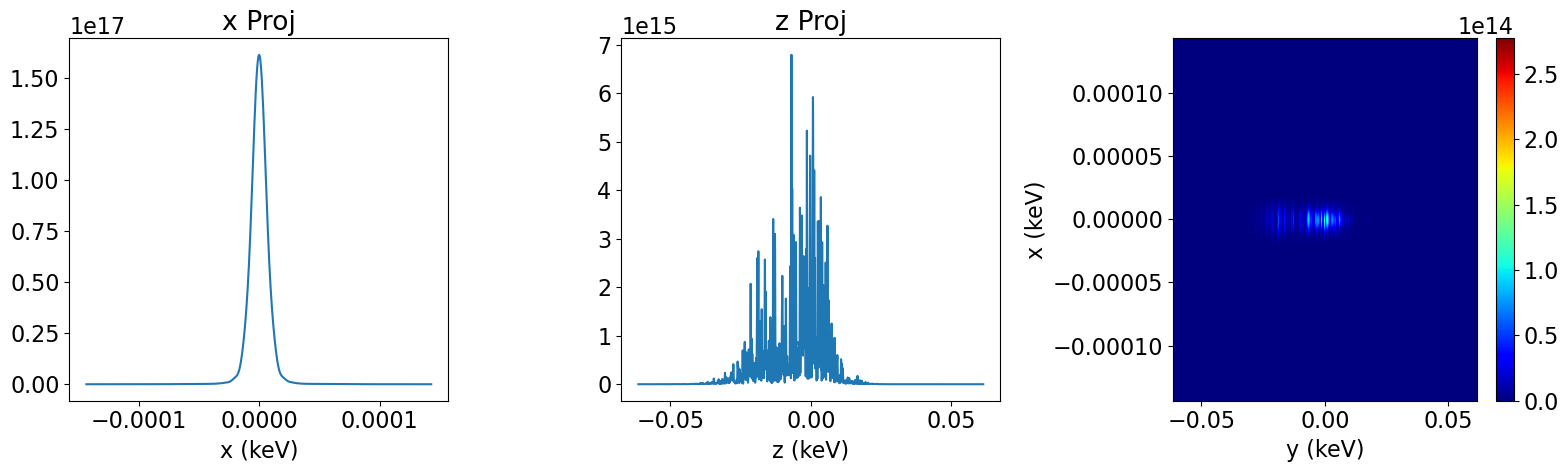

In [29]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(5)
fig.set_figwidth(16)

field_to_process = np.square(np.abs(eSpectrumInitial))
x_proj = np.sum(field_to_process, axis=1)
z_proj = np.sum(field_to_process, axis=0)

axes[0].plot(ExCoor, x_proj)
axes[0].set_title("x Proj")
axes[0].set_xlabel("x (keV)")

axes[1].plot(EzCoor, z_proj)
axes[1].set_title("z Proj")
axes[1].set_xlabel("z (keV)")

img1 = axes[2].imshow(field_to_process, aspect="auto", cmap='jet',
                      extent=[EzCoor.min(), EzCoor.max(), ExCoor.min(), ExCoor.max(), ])
fig.colorbar(img1, ax=axes[2])
axes[2].set_ylabel("x (keV)")
axes[2].set_xlabel("y (keV)")

plt.tight_layout()
plt.show()


# Propagate the pulse by some distance

In [30]:
# Get frequency
omega = np.zeros((nx, nz))
omega += np.square(kxCoor[:, np.newaxis])
omega += np.square(kzCoor[np.newaxis, :])
omega = np.sqrt(omega) * util.c

# Get distance
propDistance = 200e6

# Get time
t = propDistance / util.c

# Get the phase 
propagationPhaseComplex = np.exp(1.j * (kzCoor[np.newaxis, :] * propDistance - omega * t))
del omega

# Add the propagation phase
eSpectrumPropagation = np.multiply(eSpectrumInitial, propagationPhaseComplex)

# Get the field profile after propagation
eFieldPropagation = np.fft.ifftn(np.fft.ifftshift(eSpectrumPropagation))

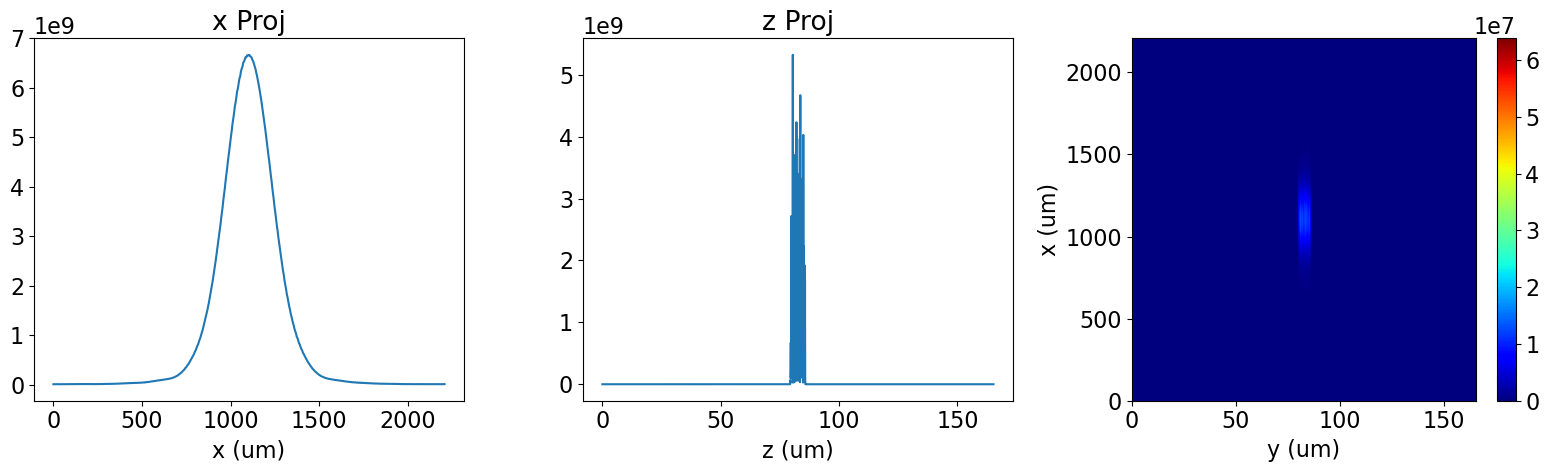

In [31]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(5)
fig.set_figwidth(16)

field_to_process = np.square(np.abs(eFieldPropagation))
x_proj = np.sum(field_to_process, axis=1)
z_proj = np.sum(field_to_process, axis=0)
del eFieldPropagation

axes[0].plot(xCoor, x_proj)
axes[0].set_title("x Proj")
axes[0].set_xlabel("x (um)")

axes[1].plot(zCoor, z_proj)
axes[1].set_title("z Proj")
axes[1].set_xlabel("z (um)")

img1 = axes[2].imshow(field_to_process, aspect="auto", cmap='jet',
                      extent=[zCoor.min(), zCoor.max(), xCoor.min(), xCoor.max(), ])
fig.colorbar(img1, ax=axes[2])
axes[2].set_ylabel("x (um)")
axes[2].set_xlabel("y (um)")

plt.tight_layout()
plt.show()


In [32]:
util.get_fwhm(xCoor, x_proj)

311.0400000000001

# Create crystals

In [10]:
# Create two channel cut crystals
myCrystalsCC = [Crystal.ChannelCut(crystal_type="Silicon",
                                   miller_index="220",
                                   energy_keV=10.0,
                                   thickness_list=np.array([1e4, 1e4]),
                                   gap=2e4,
                                   edge_length_list=np.array([5e4, 5e4]),
                                   asymmetry_angle_list=np.deg2rad(np.array([0., 0.])),
                                   first_surface_loc="lower left",
                                   source="./crystal_property_Silicon_220_10.00keV.pickle"),

                Crystal.ChannelCut(crystal_type="Silicon",
                                   miller_index="220",
                                   energy_keV=10.0,
                                   thickness_list=np.array([1e4, 1e4]),
                                   gap=2e4,
                                   edge_length_list=np.array([5e4, 5e4]),
                                   asymmetry_angle_list=np.deg2rad(np.array([0., 0.])),
                                   first_surface_loc="upper left",
                                   source="./crystal_property_Silicon_220_10.00keV.pickle"),

                Crystal.CrystalBlock3D_auto(crystal_type="Silicon",
                                   miller_index="220",
                                   energy_keV=10.0,
                                   thickness=1e4,
                                   edge_length=5e4,
                                   asymmetry_angle=0.0,
                                   source="./crystal_property_Silicon_220_10.00keV.pickle")
                ]

In [11]:
# User defined parameter
# Always assume that the reflection location on the first crystal is at (0, 0, 0).
distance_cc1_cc2 = 100e4  # The z direction distance between the second and third reflection surface is 30cm
observation = np.array([0, 0, 4e6])  # detector position
initial_point = np.array([0, 0, -2e6])  # assume that the KB mirror / focusing lens is at this location.

##########################################################
#    Align the angle of the two channel-cut crystals
##########################################################
# Define the incident wave-vector, with respect to which we will align the crystals
k0Vec = np.array([0.0, 0.0, k0])  # incident beam is along the z direction

# Align the 1st crystal
DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=myCrystalsCC[0],
                                                        kin=k0Vec,
                                                        scan_range=0.0005,
                                                        scan_number=10000)

kOut1 = DeviceSimu.get_kout_multi_device(device_list=myCrystalsCC[0].crystal_list,
                                         kin=k0Vec)

# Align the 2nd crystal
DeviceSimu.align_channel_cut_dynamical_bragg_reflection(channelcut=myCrystalsCC[1],
                                                        kin=kOut1[-1],
                                                        scan_range=0.0005,
                                                        scan_number=10000)

# Get the output wave-vector from all the crysatls
kOutArray = DeviceSimu.get_kout_multi_device(device_list=myCrystalsCC[0].crystal_list + myCrystalsCC[1].crystal_list,
                                             kin=k0Vec)

##########################################################
#    Define the spatial position of the two channel-cut crystals
##########################################################
directions = kOutArray / np.linalg.norm(kOutArray, axis=-1)[:, np.newaxis]

# The center of the first crystal is at the location (0,0,0)
myCrystalsCC[0].shift(displacement=-np.copy(myCrystalsCC[0].crystal_list[0].surface_point),
                      include_boundary=True)

# Move the second channel-cut crystal to match the crystal distance. 
displacement = np.array([0, 0, distance_cc1_cc2])
displacement += myCrystalsCC[0].crystal_list[1].surface_point - myCrystalsCC[1].crystal_list[0].surface_point

myCrystalsCC[1].shift(displacement=displacement, include_boundary=True)

# Calculate the trajectory and adjust the spatial offset induced by the channel-cut.
(intersectionList,
 kOutArray,
 pathLength) = DeviceSimu.get_lightpath(device_list=myCrystalsCC[0].crystal_list + myCrystalsCC[1].crystal_list,
                                        kin=k0Vec,
                                        initial_point=np.copy(initial_point),
                                        final_plane_point=observation,
                                        final_plane_normal=directions[-1])

intersectionArray = np.vstack(intersectionList)

# Shift the initial position and the crystals
initial_point -= intersectionArray[-1]
myCrystalsCC[0].shift(displacement=-np.copy(intersectionArray[-1]))
myCrystalsCC[1].shift(displacement=-np.copy(intersectionArray[-1]))

intersectionArray -= intersectionArray[-1][np.newaxis, :]

The geometric Bragg angle is 18.84 deg
The geometric Bragg angle is 18.84 deg


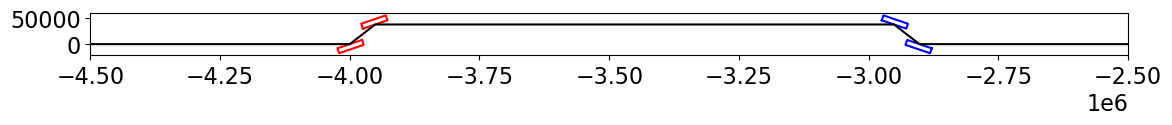

In [35]:
# Plot the channel-cut crystals
fig, axis = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(12)
fig.set_figheight(4)

color = ['r', 'b']

for x in range(2):
    for y in range(2):
        axis.plot(myCrystalsCC[x].crystal_list[y].boundary[:, 2],
                  myCrystalsCC[x].crystal_list[y].boundary[:, 1],
                  c=color[x],
                  )
axis.plot(intersectionArray[:, 2], intersectionArray[:, 1], 'k')
axis.set_aspect('equal')
axis.set_xlim([-4.5e6, -2.5e6])

plt.tight_layout()
plt.show()

# Bragg Reflection Calculation

In [13]:
#  Get k gird to calculate the reflectivity and get the output pulse
kVecGridInitial = np.zeros((nx, nz, 3), dtype=np.float64)
kVecGridInitial[:, :, 0] = kxCoor[:, np.newaxis]
kVecGridInitial[:, :, 2] = kzCoor[np.newaxis, :]

# Make it flat
kVecGridInitial = np.reshape(kVecGridInitial, (nx * nz, 3))

In [14]:
#  Prepare the spectrum
eSpectrumPropagation = np.reshape(eSpectrumPropagation, nx * nz)
eSpectrumPropagation = np.ascontiguousarray(eSpectrumPropagation)

In [15]:
batchNum = 16

# Get the time
tic = time.time()
output_dict = GPUMultiDevice.get_multicrystal_reflection(kin_grid=kVecGridInitial,
                                                         spectrum_in=eSpectrumPropagation,
                                                         device_list=myCrystalsCC[0].crystal_list + myCrystalsCC[1].crystal_list,
                                                         total_path=pathLength,
                                                         initial_position=initial_point,
                                                         batch_num=batchNum,
                                                         d_num=512,
                                                         flag_reflectivity=False,
                                                         flag_jacobian=False,
                                                         flag_kout=True,
                                                         flag_kout_length=False,
                                                         flag_phase=False)
# Get the time
toc = time.time()
print("It takes {:.2f} seconds to finish the calculation.".format(toc - tic))

/home/haoyuan/miniconda3/envs/XRaySimulation/lib/python3.8/site-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


It takes 1.16 seconds to finish the calculation.


In [16]:
eFieldCC = np.fft.ifftn(np.fft.ifftshift(np.reshape(output_dict['spectrum_grid'], (nx, nz))))

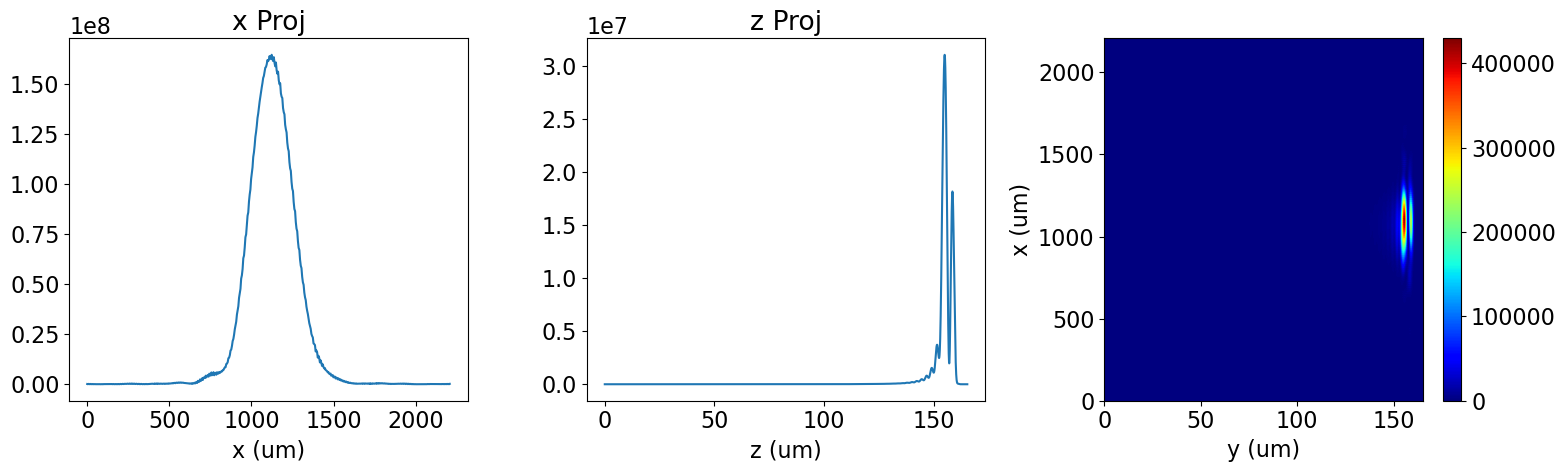

In [23]:
fig, axes = plt.subplots(ncols=3, nrows=1)
fig.set_figheight(5)
fig.set_figwidth(16)

field_to_process = np.square(np.abs(eFieldCC))
# Roll the electric field to the center
x_proj = np.sum(field_to_process, axis=1)
z_proj = np.sum(field_to_process, axis=0)

deltaZ = np.argmax(z_proj)
field_to_process = np.roll(field_to_process, (0, nz - deltaZ - 2 ** 10))
z_proj = np.roll(z_proj, nz - deltaZ - 2 ** 10)

axes[0].plot(xCoor, x_proj)
axes[0].set_title("x Proj")
axes[0].set_xlabel("x (um)")

axes[1].plot(zCoor, z_proj)
axes[1].set_title("z Proj")
axes[1].set_xlabel("z (um)")

img1 = axes[2].imshow(np.abs(field_to_process), aspect="auto", cmap='jet',
                      extent=[zCoor.min(), zCoor.max(), xCoor.min(), xCoor.max(), ])
fig.colorbar(img1, ax=axes[2])
axes[2].set_ylabel("x (um)")
axes[2].set_xlabel("y (um)")

plt.tight_layout()
plt.show()

In [36]:
np.save("/mnt/c/Users/haoyuan/Desktop/PosDoc/BraggTG/output/efield_afterSD_2d_{}.npy".format(pulseIdx), eFieldCC)
np.save("/mnt/c/Users/haoyuan/Desktop/PosDoc/BraggTG/output/eSpectrum_afterSD_2d_{}.npy".format(pulseIdx), np.reshape(output_dict['spectrum_grid'], (nx, nz)))

TypeError: _save_dispatcher() missing 1 required positional argument: 'arr'